## Preprocess and explore datasets

In [1]:
import pandas as pd
import folium as fol
import geohash2 as gh
import seaborn as sns
import geopandas as gpd
from folium import plugins
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [2]:
ds_path = r'C:\Users\jose.luigi.s.torres\Desktop\aiforsea\traffic_management\data\training.csv'

df = pd.read_csv(ds_path)

In [3]:
######### TEST ON SUBSET FIRST #########
subset_test = pd.DataFrame(df.loc[:100,])
decoded = subset_test.geohash6.apply(lambda x: gh.decode_exactly(x))
subset_test['lat'] = decoded.apply(lambda x: x[0])
subset_test['long'] = decoded.apply(lambda x: x[1])

subset_test['hour'] = subset_test.timestamp.str.split(':').str[0]
subset_test['min'] = subset_test.timestamp.str.split(':').str[1]

geom_test = [Point(xy) for xy in zip(subset_test.lat.astype('float'),subset_test.long.astype('float'))]
gdf_test = gpd.GeoDataFrame(subset_test,geometry=geom_test)

subset_test.drop(['geohash6'],axis=1,inplace=True)

In [4]:
# preprocess coordinates
decoded = df.geohash6.apply(lambda x: gh.decode_exactly(x))
df['lat'] = decoded.apply(lambda x: x[0])
df['long'] = decoded.apply(lambda x: x[1])

# convert to geodataframe
geom = [Point(xy) for xy in zip(df.lat.astype('float'),df.long.astype('float'))]
gdf = gpd.GeoDataFrame(df,geometry=geom)

In [5]:
gdf['hour'] = gdf.timestamp.str.split(':').str[0]
gdf['min'] = gdf.timestamp.str.split(':').str[1]

gdf['hour'] = gdf['hour'].astype('int')
gdf['min'] = gdf['min'].astype('int')


gdf.drop(['geohash6',],axis=1,inplace=True)

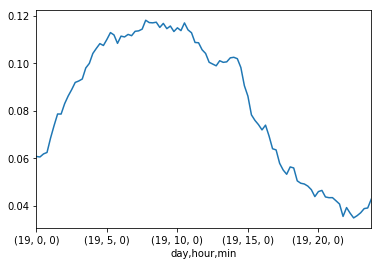

In [6]:
gdf.query('day==19').groupby(['day','hour','min']).demand.mean().plot()

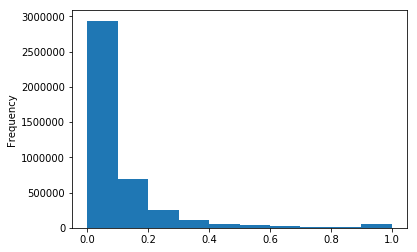

In [7]:
# get top 25% percentile demand locations
gdf.demand.plot.hist()

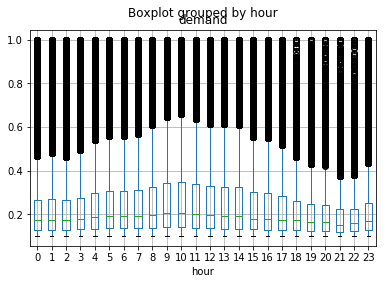

In [8]:
gdf.loc[gdf.demand>gdf.demand.quantile(0.7),].boxplot(column='demand',by='hour')

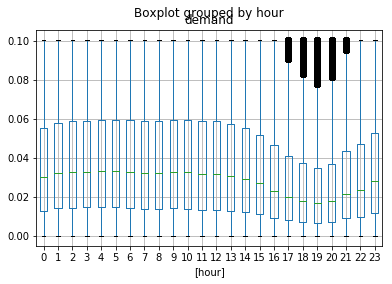

In [9]:
gdf.loc[gdf.demand<gdf.demand.quantile(0.7),].boxplot(column='demand',by=['hour'])

## Test for autocorrelation

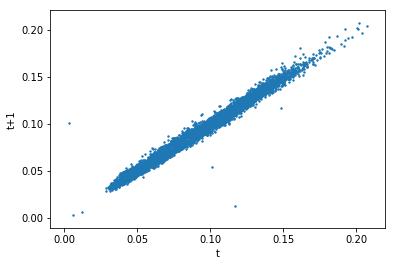

In [10]:
gdf.sort_values(['day','hour','min'],inplace=True)

agg = gdf.groupby(['day','hour','min']).demand.mean().reset_index()

t = agg.demand
t.name = "t"

t_1 = agg.demand.shift(-1)
t_1.name = ("t+1")

demand_corr = pd.concat([t,t_1],axis=1).dropna(how="any",axis=0)

demand_corr.plot.scatter(x="t",y="t+1",s=2)

In [11]:
demand_corr.corr()

,t,t+1
t,1.000000,0.991971
t+1,0.991971,1.000000


In [ ]:
from pandas.plotting import lag_plot
lag_plot(agg)

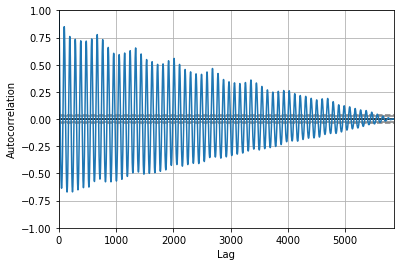

In [12]:
pd.plotting.autocorrelation_plot(demand_corr)